In [686]:
import h5py
import numpy as np
import csv
import pandas as pd
from os import listdir
from os.path import isfile, join
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial.distance import pdist, squareform
import sys

import cv2
import numpy as np
from cv2 import VideoWriter, VideoWriter_fourcc
from matplotlib import animation, rc
from IPython.display import HTML

from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.lines as mlines

%matplotlib inline
path = '/home/roozbeh/Vascularization/VascularizationData/'

In [951]:
# Plotting functions

def show_image(path):
    """
    Parameters:
    -----------
    path: str
    the directory path to the image. The format of image can be .tif or .png
    
    Return:
    -------
    plot to show
    
    """
    plt.figure(figsize=(18,18))
    im = Image.open(path)
    imarray = np.array(im)
    plt.imshow(imarray)

def draw_line(p1, p2):
    """
    Parameters:
    -----------
    p1, p2: list
        p1 and p2 are two points in 2D as list. For example, p1 = [x, y] = [324, 54]
    
    Return:
    -------
    line: a mline object from matplotlib.lines
        the line connect p1 to p2
    """
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D(p1, p2)
    ax.add_line(l)
    return l

def show_pts(volume, centroids, p1, p2, window_size, connected_path):
    
    """
    plotting the centroid and the mask volume.
    
    Parameters:
    -----------
    volume: narray of dim = 3
        volume has dimention 3 with the corrdinates corresponding to x,y,z respectively.
        
    centroids: narray of dim = 2 
        Shape of centroids is [3 * n_centroids], where n_centroids is
        the number of centroids.
        
    p1, p2: list
        p1 and p2 are two points in 3D as list. For example, p1 = [x, y, z] = [324, 54, 12]
    
    window_size: int
        the margin of the volume that is included in the analysis.
        For example the range [x_min-window_size:x_max+window_size] uses for x asis in the analysis.
    
    connected_path: list
        list of indices for centroids that connects p1 to p2 (including them as the first and last indices). 
    
    Return:
    -------
    Plotting the centroids overlaied with mask.
    
    """
    x_min, y_min, z_min, x_max, y_max, z_max = boundries(volume, 
                                                         p1, p2, 
                                                         window_size,
                                                         z_to_xy_ratio=z_to_xy_ratio)
    for i in range(0, z_max-z_min):
        #plt.subplot(4, 4, i+1)
        plt.imshow(volume[x_min-w:x_max+w, y_min-w:y_max+w, i+z_min])
        subset_centroid = np.where(abs(centroids[2, :]-i+2)<1)[0]
        #print(abs(centroids[2]-i+z_min))
        #print(centroids[2])
        plt.scatter(centroids[1][subset_centroid]-y_min+w,
                    centroids[0][subset_centroid]-x_min+w, color='r', alpha=.5)
        plt.scatter(p1[1]-y_min+w, p1[0]-x_min+w, color='blue')
        plt.scatter(p2[1]-y_min+w, p2[0]-x_min+w, color='blue', marker=5) 
        plt.show()
        
    ax = 1
    plt.scatter(centroids[ax,:], centroids[0,:],  color='red')

    for i in connected_path:
        plt.scatter(centroids[ax, i], centroids[0, i], color='green')

    plt.scatter(centroids[ax, connected_path[0]], centroids[0, connected_path[0]], color='blue', s = 70)
    plt.scatter(centroids[ax, connected_path[-1]], centroids[0, connected_path[-1]], color='blue', s = 70)
    plt.axis('equal')

def make_3d(path):
    """
    Parameters:
    -----------
    path: str
    the directory path to the image data. The directory should contains .tiff files for 
    z sections. The 3d array is stack based in alphabetical order on the names of tiff files.
    
    Return:
    -------
    volume: narray
        numpy array of dim = 3 where the axis are corresponding to x, y and z.
        
    """
    tiff_files = np.sort([f for f in listdir(path) if isfile(join(path, f))])
    im = np.array(Image.open(path+tiff_files[0])).T
    
    volume = np.zeros([im.shape[0], im.shape[1], len(tiff_files)])
    for i in range(len(tiff_files)):
        volume[:,:, i] = np.array(Image.open(path+tiff_files[i])).T
    return volume


z_to_xy_ratio = .3

def is_on_edge(p1):
    
    """
    Parameters:
    -----------
    p1: list
        p1 is a point in 3D as list. For example, p1 = [x, y, z] = [324, 54, 12]   


    Return:
    -------
    Boolean: True of False
        it returns whether p1 is close to the edges of image.
        
    """
    if p1[1]< 50 or p1[1]>450:
        return True
    else:
        return False



def boundries(volume, 
              p1, p2, 
              window_size, 
              z_to_xy_ratio=z_to_xy_ratio):
    """
    Parameters:
    -----------
    volume: narray
        numpy array of dim = 3 where the axis are corresponding to x, y and z.
        
    p1, p2: list
        p1 and p2 are two points in 3D as list. For example, p1 = [x, y, z] = [324, 54, 12].
        
    window_size: int
        the margin of the volume that is included in the analysis.
        For example the range [x_min-window_size:x_max+window_size] uses for x asis in the analysis.
    
    z_to_xy_ratio: float
        the ratio of the resolution in z axis to xy plane.
    
    Return:
    -------
    x_min, y_min, z_min, x_max, y_max, z_max: float
        the boundary of the image for the futher analysis of finding centroids.
        
    """
    [x_1, y_1, z_1] = p1
    [x_2, y_2, z_2] = p2

    x_min = max(min(x_1, x_2)-window_size, 0)
    y_min = max(min(y_1, y_2)-window_size, 0)
    z_min = max(min(z_1, z_2)-int(z_to_xy_ratio*window_size), 0)

    x_max = min(max(x_1, x_2)+window_size, volume.shape[0])
    y_max = min(max(y_1, y_2)+window_size, volume.shape[1])
    z_max = min(max(z_1, z_2)+int(z_to_xy_ratio*window_size), volume.shape[2])
    return x_min, y_min, z_min, x_max, y_max, z_max

def centroid_between_pts(volume, 
                         p1,
                         p2,
                         window_size=4,
                         pad = [4, 4, 2]):
    """
    Using Kmeans to find the centroids in a volume.
    
    Parameters:
    -----------
    volume: narray
        numpy array of dim = 3 where the axis are corresponding to x, y and z.
        
    p1, p2: list
        p1 and p2 are two points in 3D as list. For example, p1 = [x, y, z] = [324, 54, 12].
        
    window_size: int
        the margin of the volume that is included in the analysis.
        For example the range [x_min-window_size:x_max+window_size] uses for x asis in the analysis.
        
    pad: list of three int
        distance of moving wndow for finding centroids.
    
    Return:
    -------
    centroids: narray of dim = 2 
        Shape of centroids is [3 * n_centroids], where n_centroids is
        the number of centroids.
        
    cen_p1, cen_p2: int
        the indices of closest points to p1 and p2 in centroids.
    
    """    
    x_min, y_min, z_min, x_max, y_max, z_max = boundries(volume, p1, p2, window_size)
    
    ########## Kmean idea ################
#     I = np.ix_(np.arange(x_min, x_max), np.arange(y_min, y_max), np.arange(z_min, z_max))
#     subvolume = volume[I]
#     [x,y,z] = np.where(subvolume==1)
#     locations = np.zeros([3,len(x)])
#     locations[0] = x + x_min
#     locations[1] = y + y_min
#     locations[2] = z + z_min

#     kmeans = KMeans(n_clusters=n_clusters)
#     kmeans = kmeans.fit(locations.transpose())
#     centroids = kmeans.cluster_centers_.transpose()

    ########## meash idea ################
    centroids = np.zeros([3, 1])
    for x1 in np.arange(x_min, x_max, pad[0]):
        for y1 in np.arange(y_min, y_max, pad[1]):            
            for z1 in np.arange(z_min, z_max, pad[2]):
                I = np.ix_(np.arange(x1-pad[0], x1), np.arange(y1-pad[1], y1), np.arange(z1-pad[2], z1))
                subvolume = volume[I]
                [x, y, z] = np.where(subvolume==1)
                if len(x)>0:                  
                    new_pt = np.array([x[0]+ x1-pad[0], y[0]+ y1-pad[1], z[0]+ z1-pad[2]])
                    new_pt = np.expand_dims(new_pt, 1)
                    centroids = np.concatenate((centroids, new_pt), axis=1)
    if centroids.shape[1] > 1:
        centroids = centroids[:, 1:]

    ########## p1 and p2 in the centroids ################
    closest, _ = pairwise_distances_argmin_min(centroids.transpose(), [p1], axis=0)
    cen_p1 = closest[0]
    closest, _ = pairwise_distances_argmin_min(centroids.transpose(), [p2], axis=0)
    cen_p2 = closest[0] 
    
    return centroids, cen_p1, cen_p2


class Graph(): 
  
    def __init__(self, graph): 
        self.n_vertices =  graph.shape[0]
        self.weigth_graph = graph
        self.adj_graph = np.heaviside(graph, 0)
  
    def minDistance(self, dist, sptSet): 
  
        # Initilaize minimum distance for next node 
        m = sys.maxsize 
        min_index = -1
        # Search not nearest vertex not in the  
        # shortest path tree 
        for v in range(self.n_vertices): 
            if dist[v] < m and sptSet[v] == False: 
                m = dist[v] 
                min_index = v 
  
        return min_index 
  
    # Funtion that implements Dijkstra's single source  
    # shortest path algorithm for a graph represented  
    # using adjacency matrix representation 
    def dijkstra(self, src): 
        """
        Parameters:
        -----------
        src: int
            the source vertix to find the distance of other nodes from.
            the distance is from the weigthed graph.
    
        Returns:
        -------
        dist: 1D narray of length number of vertex
            list of distance of points from src. The order of vertex is the same as the weigthed graph.
            
        path: list
            path[i] is the indices of the vertices that connect src to vertex[i]
        """  
        dist = [sys.maxsize] * self.n_vertices
        dist[src] = 0
        sptSet = [False] * self.n_vertices
        path = self.n_vertices*[[src]]
        for cout in range(self.n_vertices):
  
            # Pick the minimum distance vertex from  
            # the set of vertices not yet processed.  
            # u is always equal to src in first iteration 
            u = self.minDistance(dist, sptSet) 
            if u>=0:
            # Put the minimum distance vertex in the  
            # shotest path tree 
                sptSet[u] = True

                # Update dist value of the adjacent vertices  
                # of the picked vertex only if the current  
                # distance is greater than new distance and 
                # the vertex in not in the shotest path tree 
                for v in range(self.n_vertices): 
                    if self.adj_graph[u][v] > 0 and \
                        sptSet[v] == False and \
                        dist[v] > dist[u] + self.weigth_graph[u][v]: 
                        dist[v] = dist[u] + self.weigth_graph[u][v]
                        path[v] = path[u] +[u]
            else:
                break
        dist = np.array(dist)
        dist[np.where(dist==sys.maxsize)] = -1 
        return dist, path
    
def pts_connecting_two_branching(centroids, 
                                 branch_1,
                                 branch_2,
                                 z_to_xy_ratio=z_to_xy_ratio, 
                                 thrshold_connecting=5):
    """
    Parameters:
    -----------
    centroids: narray of dim = 2 
        Shape of centroids is [3 * n_centroids], where n_centroids is
        the number of centroids.

    branch_1 and branch_2: int
        the indices of initial branch and end branch in the centroids.
        
    z_to_xy_ratio: float
        the ratio of the resolution in z axis to xy plane.   
        
    thrshold_connecting: float
        Points in the path connecting branch-1 to branch_2 has distance < thrshold_connecting.
        Distance is Euclidean except for z axis which is multiplied by z_to_xy_ratio.
    
    Return:
    -------
    path: list
        list of indices in the cetorids that connect branch_1 to branch_2.
    """
    relative_location = centroids
    relative_location[2, :] = z_to_xy_ratio*relative_location[2, :]
    graph = squareform(pdist(centroids.T, p=2)) 
    graph[graph > thrshold_connecting] = 0
    G = Graph(graph) 
    dist, path = G.dijkstra(branch_1)
    connected_path = path[cen_p2][1:]
    connected_path = connected_path + [cen_p2]
    return connected_path


def get_skeleton(volume, 
                 branchinfo,
                 window_size=15,
                 pad=[4,4,3],
                 thrshold_connecting=5):
    """
    Parameters:
    -----------
    volume: narray
        numpy array of dim = 3 where the axis are corresponding to x, y and z.
    
    branchinfo: Dataframe
        dataframe of branching points.

    window_size: int
        the margin of the volume that is included in the analysis.
        For example the range [x_min-window_size:x_max+window_size] uses for x asis in the analysis.

    pad: list of three int
        distance of moving wndow for finding centroids.
        
    z_to_xy_ratio: float
        the ratio of the resolution in z axis to xy plane.   
        
    thrshold_connecting: float
        Points in the path connecting branch-1 to branch_2 has distance < thrshold_connecting.
        Distance is Euclidean except for z axis which is multiplied by z_to_xy_ratio.
    
    Return:
    -------
    skeleton: dataframe
        contains columns of named:  'V1 x', 'V1 y', 'V1 z', 'V2 x', 'V2 y','V2 z'
        for each two connect points.
        
    """
    V1_locations = np.zeros([3, 1])
    V2_locations = np.zeros([3, 1])
    for index in range(len(branchinfo['V1 x'])):
        print(index)
        p1 = [branchinfo['V1 x'][index], branchinfo['V1 y'][index], branchinfo['V1 z'][index]]
        p2 = [branchinfo['V2 x'][index], branchinfo['V2 y'][index], branchinfo['V2 z'][index]]

        if is_on_edge(p1) is False and is_on_edge(p2) is False:
            centroids, cen_p1, cen_p2 = centroid_between_pts(volume=volume_mask, 
                                                             window_size = window_size,
                                                             pad = pad,
                                                             p1=p1, 
                                                             p2=p2)
            connected_path = pts_connecting_two_branching(centroids=centroids, 
                                                          thrshold_connecting=thrshold_connecting,
                                                          branch_1=cen_p1,
                                                          branch_2=cen_p2)
            V1_locations = np.concatenate((V1_locations, centroids[:, connected_path[:-1]]), 1)
            V2_locations = np.concatenate((V2_locations, centroids[:, connected_path[1:]]), 1)
        locations = np.concatenate((V1_locations, V2_locations),0)
        locations = locations[:, 1:]
        skeleton = pd.DataFrame(locations.transpose(),
                       columns=[ 'V1 x', 'V1 y', 'V1 z', 'V2 x', 'V2 y','V2 z'])
    return skeleton

def plot_skeleton(skeleton):
    plt.figure(figsize=(18,6))
    plt.scatter(skeleton['V1 x'], skeleton['V1 y'], color='r') 
    plt.scatter(skeleton['V2 x'], skeleton['V2 y'], color='r')

    for i in range(skeleton.shape[0]):
        p1 = [skeleton['V1 x'][i], skeleton['V2 x'][i]]
        p2 = [skeleton['V1 y'][i], skeleton['V2 y'][i]]
        draw_line(p1,p2)

## Plotting data in the files


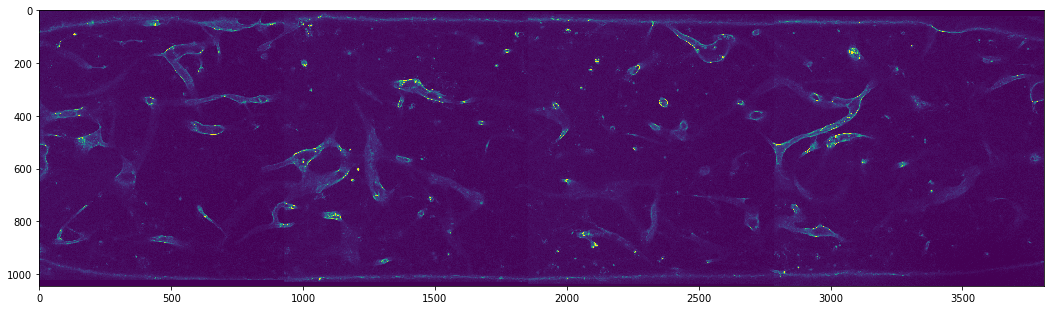

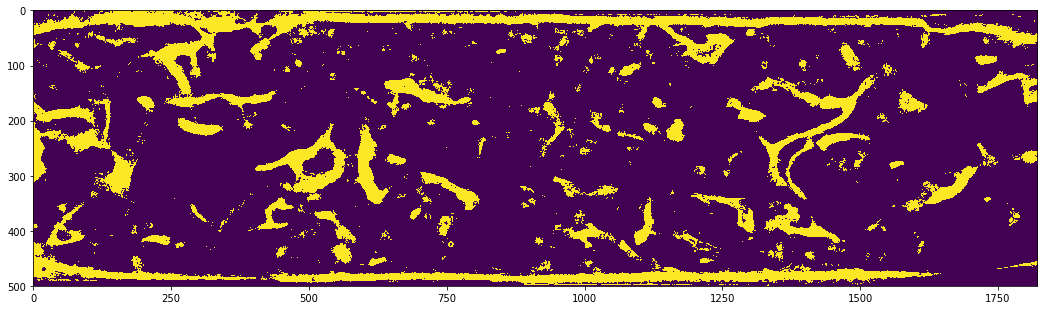

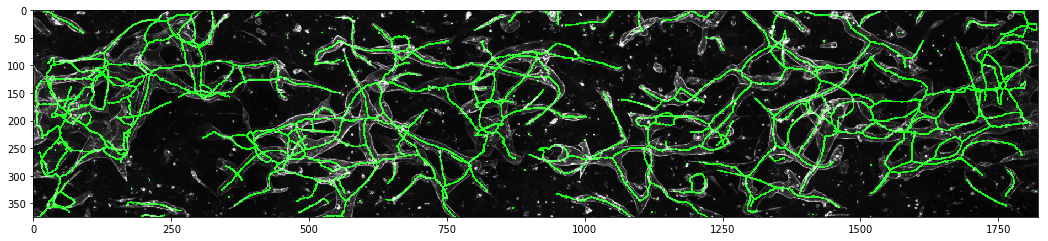

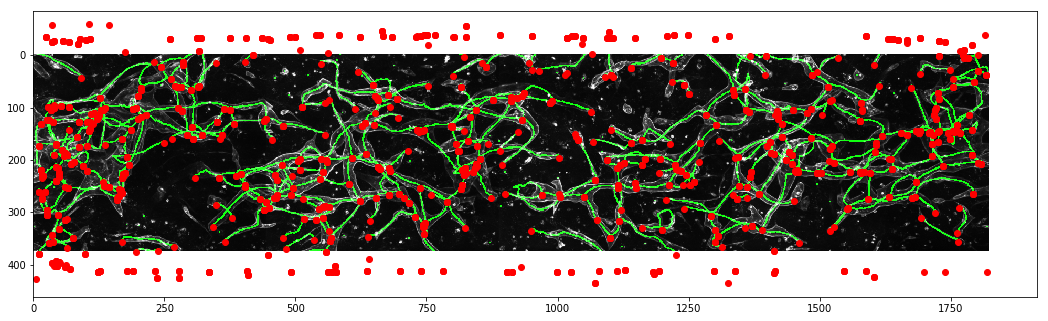

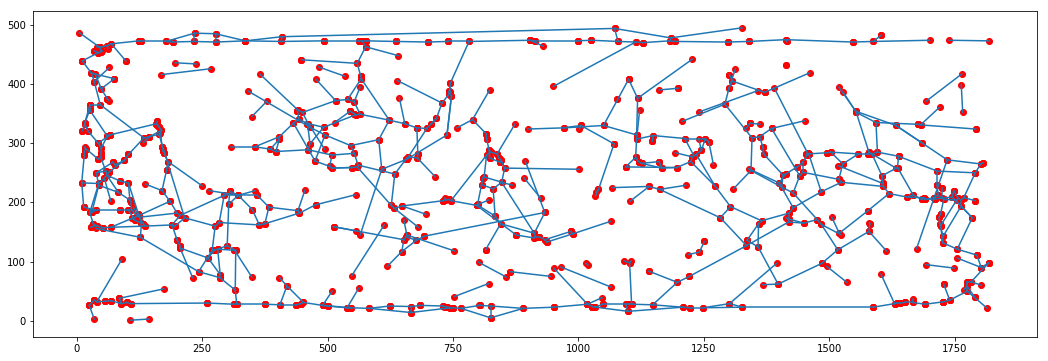

In [713]:
show_image(path=path+'Raw/P4-1-1-Stitching/P4-1-1_z06.tif')
show_image(path=path+'Segmented/P4-1-1/P4-1-1_06.tiff')
show_image(path=path+'Data/P4-1-1_MAXskeleton.tif')

branchinfo=pd.read_csv(path+'Data/P4-1-1_BranchInfo.csv')
show_image(path=path+'Data/P4-1-1_MAXskeleton.tif')
plt.scatter(branchinfo['V1 x'], branchinfo['V1 y']-60, color='r') 
plt.scatter(branchinfo['V2 x'], branchinfo['V2 y']-60, color='r')

plt.figure(figsize=(18,6))
plt.scatter(branchinfo['V1 x'], branchinfo['V1 y'], color='r') 
plt.scatter(branchinfo['V2 x'], branchinfo['V2 y'], color='r')

for i in range(branchinfo.shape[0]):
    p1 = [branchinfo['V1 x'][i], branchinfo['V2 x'][i]]
    p2 = [branchinfo['V1 y'][i], branchinfo['V2 y'][i]]
    draw_line(p1,p2)

## Reading Data

In [ ]:
branchinfo=pd.read_csv(path+'Data/P4-1-1_BranchInfo.csv')
volume_mask = make_3d(path+'Segmented/P4-1-1/')-254
volume_real = make_3d(path+'Raw/P4-1-1-Stitching/')

## Connecting two branching points

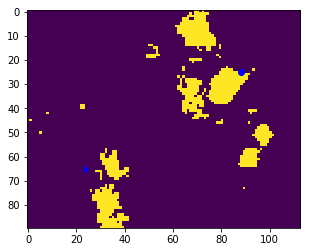

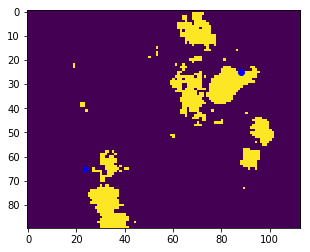

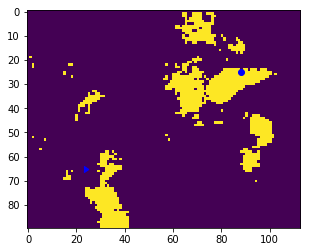

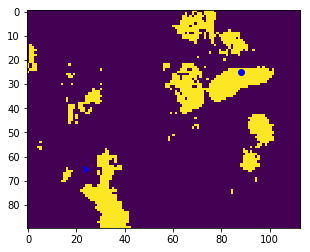

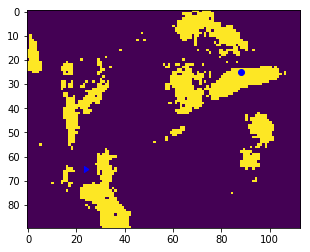

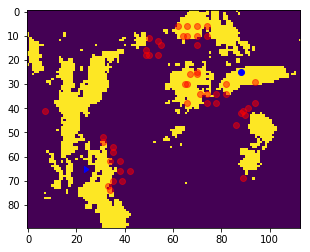

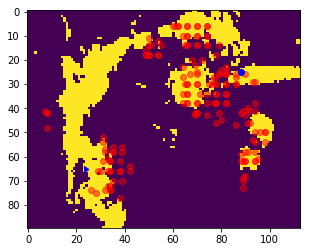

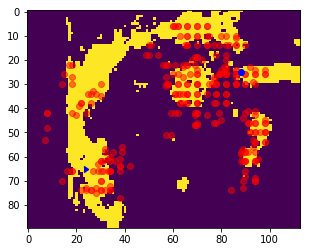

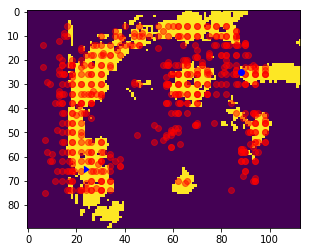

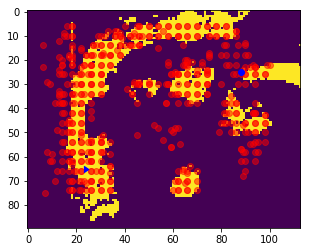

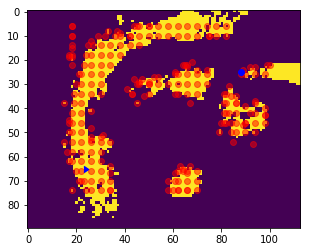

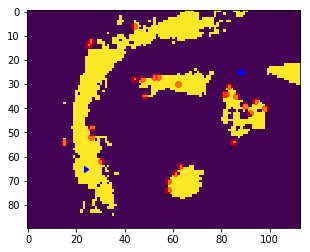

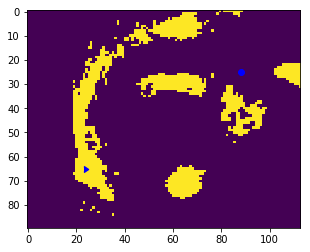

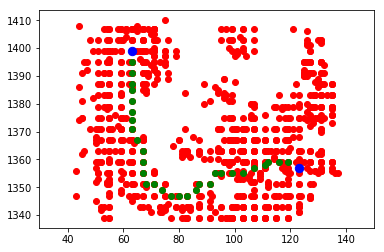

In [918]:
# To see the results for other pair of branchings, change index:
index = 20
p1 = [branchinfo['V1 x'][index], branchinfo['V1 y'][index], branchinfo['V1 z'][index]]
p2 = [branchinfo['V2 x'][index], branchinfo['V2 y'][index], branchinfo['V2 z'][index]]

# Global parameters
window_size = 15
pad = [4,4,3]
thrshold_connecting = 5
if is_on_edge(p1) is False and is_on_edge(p2) is False:
    centroids, cen_p1, cen_p2 = centroid_between_pts(volume=volume_mask, 
                                                     window_size = window_size,
                                                     pad = pad,
                                                     p1=p1, 
                                                     p2=p2)
    connected_path = pts_connecting_two_branching(centroids=centroids, 
                                                  thrshold_connecting=thrshold_connecting,
                                                  branch_1=cen_p1,
                                                  branch_2=cen_p2)
    show_pts(volume=volume_mask, 
         centroids=centroids, 
         connected_path=connected_path,
         p1=p1, 
         p2=p2, 
         window_size=window_size)

## Running over all segments

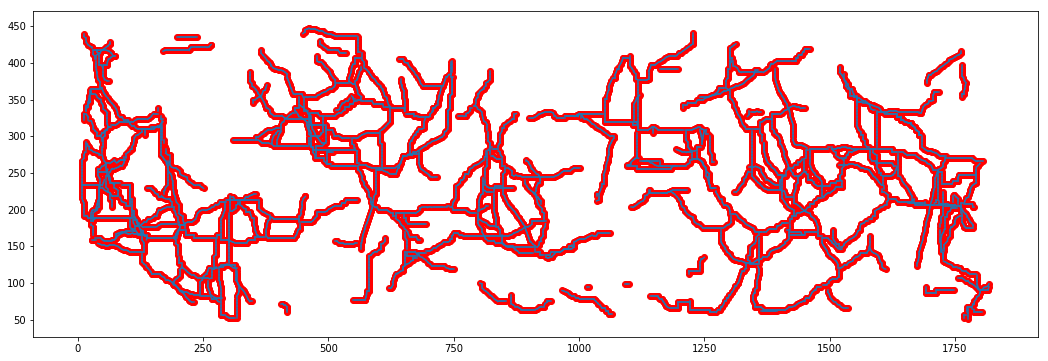

In [950]:
skeleton = get_skeleton(branchinfo=branchinfo, volume=volume_mask)
plot_skeleton(skeleton)